## Самостоятельная реализация свертки

In [ ]:
import torch
from torch import nn

In [ ]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

In [ ]:
X = torch.Tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.Tensor([[0, 1], [2, 3]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## Lenet

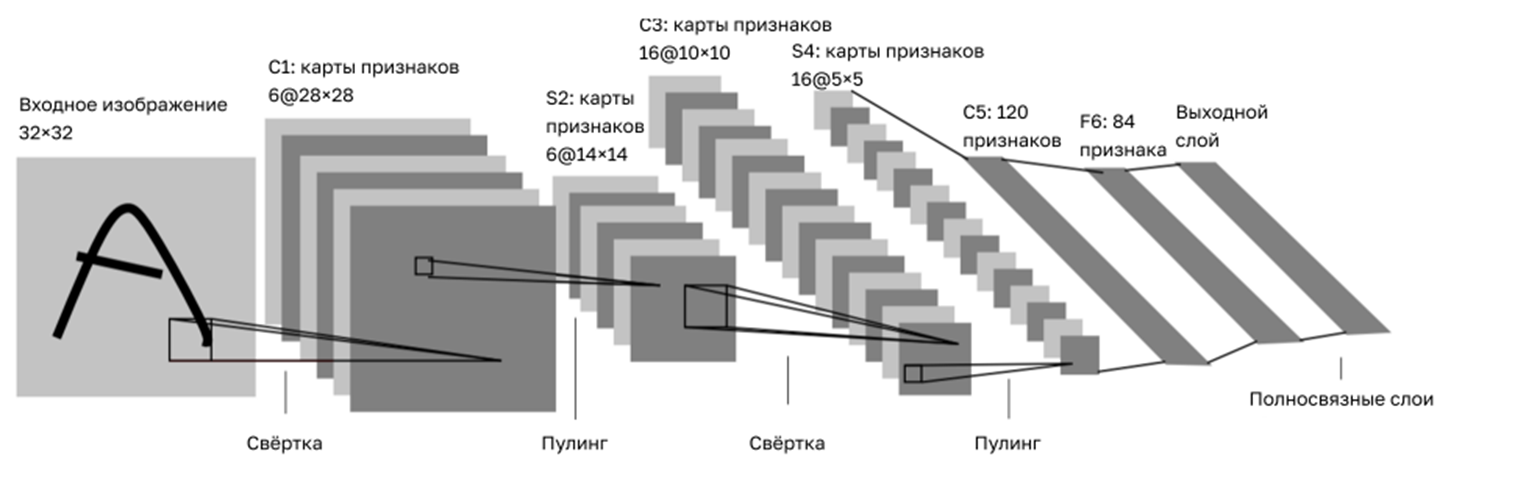

Перед вами первая (1998 год) свёрточная нейронная сеть. Реализуем её на практике в современных условиях.

In [ ]:
import torchvision as tv
import time
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 256 # Весь набор данных разбивается на "батчи" - связки по 256 объектов

`transforms` - это специальный набор методов (который можно дополнить своим методом), позволяюим преобразовывать входные данных. В данном случае нужно сделать resize (на всякий случай) и перевод в тензор.

In [ ]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize(32),
    tv.transforms.ToTensor()
])

`datasets` - реализует стандартный шаблон для работы с данными.
`DataLoader` - реализует стандратный шаблон для "подачи" данных в обучающую модель.

In [ ]:
train_dataset = tv.datasets.MNIST('.',
                                  train=True,
                                  transform=transforms,
                                  download=True)

test_dataset = tv.datasets.MNIST('.',
                                 train=False,
                                 transform=transforms,
                                 download=True)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 5)

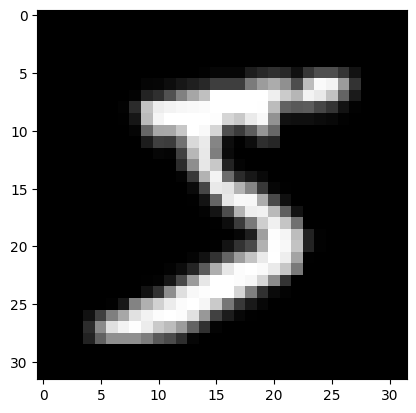

In [ ]:
plt.imshow(train_dataset[0][0].numpy().reshape(32,32), cmap='gray');

Модель нейронной сети - контейнер `Sequential`.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(16, 120, kernel_size=5),
    nn.Flatten(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)

Обратите внимание на число параметров.

In [ ]:
from torchsummary import summary

summary(model, input_size=(1, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
           Flatten-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 32, 32)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 32, 32])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 6, 28, 28])
Layer Tanh(). X shape: torch.Size([1, 6, 28, 28])
Layer AvgPool2d(kernel_size=2, stride=2, padding=0). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 16, 10, 10])
Layer Tanh(). X shape: torch.Size([1, 16, 10, 10])
Layer AvgPool2d(kernel_size=2, stride=2, padding=0). X shape: torch.Size([1, 16, 5, 5])
Layer Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 120, 1, 1])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 120])
Layer Linear(in_features=120, out_features=84, bias=True). X shape: torch.Size([1, 84])
Layer Tanh(). X shape: torch.Size([1, 84])
Layer Linear(in_features=84, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [ ]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 32, 32)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, optimizer, num_epochs):
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            optimizer.zero_grad() # обнуляем градиенты
            y_hat = net(X) # предсказываем значения
            l = loss(y_hat, y) # счтаем функцию потерь
            l.backward() # считаем градиенты, которые останутся "на парметрах"
            optimizer.step() # делаем шаг, градиент в параметрах
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

Оптимизатор берёт у модели ключевые параметры.

In [ ]:
lr, num_epochs = 0.01, 15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, optimizer, num_epochs)

epoch 1, loss 0.0090, train acc 0.142, test acc 0.398, time 19.5 sec
epoch 2, loss 0.0084, train acc 0.480, test acc 0.499, time 20.5 sec
epoch 3, loss 0.0060, train acc 0.593, test acc 0.700, time 20.4 sec
epoch 4, loss 0.0037, train acc 0.750, test acc 0.795, time 19.5 sec
epoch 5, loss 0.0027, train acc 0.811, test acc 0.834, time 20.0 sec
epoch 6, loss 0.0022, train acc 0.842, test acc 0.858, time 20.1 sec
epoch 7, loss 0.0019, train acc 0.861, test acc 0.875, time 19.7 sec
epoch 8, loss 0.0017, train acc 0.876, test acc 0.884, time 20.2 sec
epoch 9, loss 0.0016, train acc 0.884, test acc 0.892, time 20.2 sec
epoch 10, loss 0.0015, train acc 0.891, test acc 0.898, time 19.5 sec
epoch 11, loss 0.0014, train acc 0.896, test acc 0.903, time 20.1 sec
epoch 12, loss 0.0013, train acc 0.900, test acc 0.907, time 20.0 sec
epoch 13, loss 0.0013, train acc 0.903, test acc 0.911, time 19.4 sec
epoch 14, loss 0.0012, train acc 0.907, test acc 0.914, time 20.0 sec
epoch 15, loss 0.0012, train 

## Обучение на GPU

Как подключить GPU почитать [здесь (на английском)](https://www.marktechpost.com/2021/01/09/getting-started-with-pytorch-in-google-collab-with-free-gpu/) и [здесь (на русском)](https://medium.com/@janpoleszczuk/%D0%BF%D0%B5%D1%80%D0%B2%D1%8B%D0%B5-%D1%88%D0%B0%D0%B3%D0%B8-%D0%B2-google-colab-9cd511581cd6)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [ ]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0022, train acc 0.854, test acc 0.862, time 16.0 sec
epoch 2, loss 0.0022, train acc 0.856, test acc 0.864, time 9.4 sec
epoch 3, loss 0.0021, train acc 0.858, test acc 0.865, time 9.5 sec
epoch 4, loss 0.0021, train acc 0.859, test acc 0.867, time 9.5 sec
epoch 5, loss 0.0021, train acc 0.861, test acc 0.868, time 9.5 sec
